# Calculate Anchor Boxes

In [3]:
import sys
sys.path.append('../../')

TODO: Install deppendencies (PyYAML, opencv-python)

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from object_detection.config.config_reader import ConfigReader
from object_detection.dataset.all_dataset import AllDataset

pd.options.mode.chained_assignment = None
plt.figure(figsize=(10,10))
%matplotlib inline

In [5]:
config_path = '/home/zvadaada/traffic-object-detection/config/yolo.yml'
config = ConfigReader(config_path)
dataset = AllDataset(config)

In [23]:
df_true = dataset.load_annotation_df()

Loading annotation dataset Udacity


  0%|          | 115/106920 [00:00<01:33, 1148.28it/s]

Loading annotation dataset RoVIT


100%|██████████| 106920/106920 [05:26<00:00, 327.55it/s]


In [24]:
df_true['class'].unique()

array(['car', 'pedestrian', 'truck', 'trafficLight', 'biker', 'bus',
       'person', 'trafficsignal', 'motorbike', 'trafficlight', 'bicycle'],
      dtype=object)

In [8]:
df_true.loc[df_true['class'] == 'pedestrian', 'class'] = 'person'
df_true.loc[df_true['class'] == 'trafficlight', 'class'] = 'trafficLight'
df_true.loc[df_true['class'] == 'trafficsignal', 'class'] = 'trafficSignal'

In [21]:
df_true.head()

,image_filename,image_w,image_h,image_d,x_min,y_min,x_max,y_max,class,dataset_name
0,1478019952686311006.jpg,1920.0,1200.0,3.0,950.0,574.0,1004.0,620.0,car,udacity
1,1478019952686311006.jpg,1920.0,1200.0,3.0,1748.0,482.0,1818.0,744.0,person,udacity
2,1478019953180167674.jpg,1920.0,1200.0,3.0,872.0,586.0,926.0,632.0,car,udacity
3,1478019953689774621.jpg,1920.0,1200.0,3.0,686.0,566.0,728.0,618.0,truck,udacity
4,1478019953689774621.jpg,1920.0,1200.0,3.0,716.0,578.0,764.0,622.0,car,udacity


### Scale cords to YOLO size

In [10]:
# calculate size ratios, img - (h, w, 3)
#width_ratio = config.image_width()/org_image_width
#height_ratio = config.image_height()/org_image_height

df_cord_label = df_true.copy()

# resize cords
df_cord_label['x_min'] = (config.image_width()/df_true['image_w']) * df_true['x_min']
df_cord_label['x_max'] = (config.image_width()/df_true['image_w']) * df_true['x_max']
df_cord_label['y_min'] = (config.image_height()/df_true['image_h']) * df_true['y_min']
df_cord_label['y_max'] = (config.image_height()/df_true['image_h']) * df_true['y_max']

In [11]:
print(max(df_true['y_max']))
print(max(df_true['x_max']))

2104.0
3246.0


### Convert to x, y, w, h

In [12]:
# convert to x, y, w, h
df_cord_label['x'] = (df_cord_label['x_min'] + df_cord_label['x_max'])/2
df_cord_label['y'] = (df_cord_label['y_min'] + df_cord_label['y_max'])/2
df_cord_label['w'] = df_cord_label['x_max'] - df_cord_label['x_min']
df_cord_label['h'] = df_cord_label['y_max'] - df_cord_label['y_min']

### Visualize clusters

In [13]:
label_color = {'car': 'red', 
               'person': 'blue', 
               'truck': 'orange',
               'bus': 'yellow',
               'trafficLight': 'grey', 
               'trafficSignal': 'black',
               'biker': 'green',
               'motorbike': 'purple',
               'bicycle': 'pink'
               }

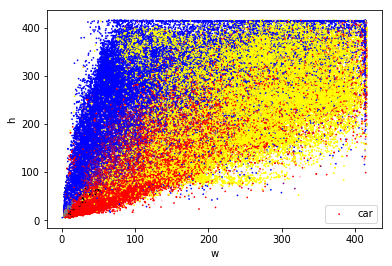

In [14]:
w = df_cord_label['w']
h = df_cord_label['h']
label = df_cord_label['class']

ax = df_cord_label.plot.scatter(x='w', y='h', c=label.apply(lambda x: label_color[x]), s=0.51, legend=True)
ax.legend(label_color.keys())

# fig, ax = plt.subplots()
# for g in np.unique(group):
#     ix = np.where(group == g)
#     ax.scatter(scatter_x[ix], scatter_y[ix], c = cdict[g], label = g, s = 100)
# ax.legend()

plt.show()

## Calculate Anchores

In [15]:
def iou(box, clusters):
    """
    Calculates the Intersection over Union (IoU) between a box and k clusters.
    :param box: tuple or array, shifted to the origin (i. e. width and height)
    :param clusters: numpy array of shape (k, 2) where k is the number of clusters
    :return: numpy array of shape (k, 0) where k is the number of clusters
    """
    x = np.minimum(clusters[:, 0], box[0])
    y = np.minimum(clusters[:, 1], box[1])
    if np.count_nonzero(x == 0) > 0 or np.count_nonzero(y == 0) > 0:
        raise ValueError("Box has no area")

    intersection = x * y
    box_area = box[0] * box[1]
    cluster_area = clusters[:, 0] * clusters[:, 1]

    iou_ = intersection / (box_area + cluster_area - intersection)

    return iou_

In [16]:
def avg_iou(boxes, clusters):
    """
    Calculates the average Intersection over Union (IoU) between a numpy array of boxes and k clusters.
    :param boxes: numpy array of shape (r, 2), where r is the number of rows
    :param clusters: numpy array of shape (k, 2) where k is the number of clusters
    :return: average IoU as a single float
    """
    return np.mean([np.max(iou(boxes[i], clusters)) for i in range(boxes.shape[0])])

In [17]:
def translate_boxes(boxes):
    """
    Translates all the boxes to the origin.
    :param boxes: numpy array of shape (r, 4)
    :return: numpy array of shape (r, 2)
    """
    new_boxes = boxes.copy()
    for row in range(new_boxes.shape[0]):
        new_boxes[row][2] = np.abs(new_boxes[row][2] - new_boxes[row][0])
        new_boxes[row][3] = np.abs(new_boxes[row][3] - new_boxes[row][1])
    return np.delete(new_boxes, [0, 1], axis=1)

In [18]:
def kmeans(boxes, k, dist=np.median):
    """
    Calculates k-means clustering with the Intersection over Union (IoU) metric.
    :param boxes: numpy array of shape (r, 2), where r is the number of rows
    :param k: number of clusters
    :param dist: distance function
    :return: numpy array of shape (k, 2)
    """
    rows = boxes.shape[0]

    distances = np.empty((rows, k))
    last_clusters = np.zeros((rows,))

    np.random.seed()

    # the Forgy method will fail if the whole array contains the same rows
    clusters = boxes[np.random.choice(rows, k, replace=False)]

    while True:
        for row in range(rows):
            distances[row] = 1 - iou(boxes[row], clusters)

        nearest_clusters = np.argmin(distances, axis=1)

        if (last_clusters == nearest_clusters).all():
            break

        for cluster in range(k):
            clusters[cluster] = dist(boxes[nearest_clusters == cluster], axis=0)

        last_clusters = nearest_clusters

    return clusters

In [19]:
data = np.array(list(zip(w, h)))

for k in range(1,8):
    print(f'K-Means with {k} clusters')
    out = kmeans(data, k=k)
    print("Accuracy: {:.2f}%".format(avg_iou(data, out) * 100))
    print("Boxes:\n {}".format(out))

    ratios = np.around(out[:, 0] / out[:, 1], decimals=2).tolist()
    print("Ratios:\n {}".format(sorted(ratios)))

K-Means with 1 clusters
Accuracy: 19.73%
Boxes:
 [[ 8.66666794 31.19999695]]
Ratios:
 [0.28]
K-Means with 2 clusters
Accuracy: 42.92%
Boxes:
 [[ 18.6333313   31.19999695]
 [ 76.2666626  134.04444885]]
Ratios:
 [0.57, 0.6]
K-Means with 3 clusters
Accuracy: 51.37%
Boxes:
 [[ 14.73332214  25.65333557]
 [ 43.875       81.4666748 ]
 [157.29998779 223.02223206]]
Ratios:
 [0.54, 0.57, 0.71]
K-Means with 4 clusters
Accuracy: 56.67%
Boxes:
 [[ 11.2666626   21.49333191]
 [ 58.82498932 107.4666748 ]
 [ 27.7333374   45.06666565]
 [194.1333313  248.44444275]]
Ratios:
 [0.52, 0.55, 0.62, 0.78]
K-Means with 5 clusters


KeyboardInterrupt: 

In [20]:
image_width = config.image_width()
image_height = config.image_height()

anchores = [[14.73332214/image_width, 25.65333557/image_height], [43.875/image_width, 81.4666748/image_height], [157.29998779/image_width, 223.02223206/image_height]]
anchores

[[0.035416639759615384, 0.06166667204326923],
 [0.10546875, 0.1958333528846154],
 [0.37812497064903844, 0.5361111347596154]]